In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# from tensorflow.keras.models import load_model
# model = load_model('model_0713_10000_epochs200.h5')

In [3]:
import pyupbit

#코인 종류 검사
tickers = pyupbit.get_tickers(fiat="KRW")

#현재 가격 확인
price = pyupbit.get_current_price("KRW-BTC")

#이전 가격 변동 확인
bit_history = pyupbit.get_ohlcv("KRW-BTC", interval="minute5", count=50000)

In [4]:
#저장된 데이터 불러오기

# bit_history = pd.read_csv("data/0730_50000.csv")
# print(bit_history)

#데이터 저장
import csv

bit_history.to_csv("data/0730_50000.csv")

In [5]:
scaler = MinMaxScaler()
scale_cols = ['open', 'high', 'low', 'volume', 'value']
scaled = scaler.fit_transform(bit_history[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)

print(df)

           open      high       low    volume     value
0      0.319142  0.316356  0.321033  0.037214  0.033930
1      0.319892  0.323832  0.322956  0.070930  0.065087
2      0.324102  0.322639  0.324273  0.047871  0.043862
3      0.321330  0.321780  0.324378  0.029778  0.027247
4      0.325019  0.321508  0.325361  0.021213  0.019434
...         ...       ...       ...       ...       ...
49995  0.220159  0.218764  0.222956  0.077045  0.063576
49996  0.222514  0.218764  0.221618  0.078757  0.064887
49997  0.218826  0.219393  0.220364  0.104530  0.086094
49998  0.223389  0.221005  0.224232  0.050219  0.041543
49999  0.223493  0.220021  0.224754  0.024740  0.020451

[50000 rows x 5 columns]


In [6]:
# train = df_scaled[:45000]
# test = df_scaled[45000:]

# # train.head()
# train.tail()
# # test.head()

x_train, x_test, y_train, y_test = train_test_split(df.drop('open', 1), df['open'], test_size=0.2, random_state=0, shuffle=False)

In [7]:
x_train.shape, y_train.shape


((40000, 4), (40000,))

In [8]:
x_test.shape, y_test.shape

((10000, 4), (10000,))

In [9]:
pd.concat([x_train, y_train], axis=1).head(65)

,high,low,volume,value,open
0,0.316356,0.321033,0.037214,0.033930,0.319142
1,0.323832,0.322956,0.070930,0.065087,0.319892
2,0.322639,0.324273,0.047871,0.043862,0.324102
3,0.321780,0.324378,0.029778,0.027247,0.321330
4,0.321508,0.325361,0.021213,0.019434,0.325019
...,...,...,...,...,...
60,0.328921,0.330358,0.010063,0.009276,0.332187
61,0.326387,0.328246,0.009539,0.008766,0.328228
62,0.323728,0.326678,0.019185,0.017595,0.325581
63,0.320859,0.322643,0.031128,0.028453,0.323789


In [10]:
WINDOW_SIZE = 60
BATCH_SIZE = 20

# ds_x = tf.data.Dataset.from_tensor_slices(x_train)
# ds_x = ds_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
# ds_x = ds_x.flat_map(lambda x: x.batch(WINDOW_SIZE))

# pd.concat([ds_x]).head(5)

In [12]:
# ds_y = tf.data.Dataset.from_tensor_slices(y_train[WINDOW_SIZE:])

# pd.concat([ds_y],axis=1).head(5)

In [13]:
# train_data = tf.data.Dataset.zip((ds_x, ds_y)).batch(32)

In [11]:
#슬라이딩 윈도우를 만드는 함수

def windowed_dataset(x, y, window_size, batch_size, shuffle):
#     series = tf.expand_dims(x, axis=-1)
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(WINDOW_SIZE))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y[WINDOW_SIZE:])

    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [14]:
for data in test_data.take(1):
    print(f"train_data : {data[0].shape}")
    print(data[0])
    print(f"test_data : {data[1].shape}")    
    print(data[1])

train_data : (20, 60, 4)
tf.Tensor(
[[[0.13271204 0.1362534  0.04604773 0.03449157]
  [0.1306178  0.13644156 0.05336664 0.03991881]
  [0.13015707 0.13600251 0.03274281 0.02447444]
  ...
  [0.16251309 0.16443655 0.09435639 0.07309946]
  [0.16452356 0.16725904 0.10818397 0.08404956]
  [0.16190576 0.16617186 0.07237401 0.05606939]]

 [[0.1306178  0.13644156 0.05336664 0.03991881]
  [0.13015707 0.13600251 0.03274281 0.02447444]
  [0.13310995 0.13602342 0.02966138 0.02219537]
  ...
  [0.16452356 0.16725904 0.10818397 0.08404956]
  [0.16190576 0.16617186 0.07237401 0.05606939]
  [0.16224084 0.16780263 0.04180316 0.03243919]]

 [[0.13015707 0.13600251 0.03274281 0.02447444]
  [0.13310995 0.13602342 0.02966138 0.02219537]
  [0.13472251 0.13884591 0.0526783  0.03956696]
  ...
  [0.16190576 0.16617186 0.07237401 0.05606939]
  [0.16224084 0.16780263 0.04180316 0.03243919]
  [0.16224084 0.16621367 0.06264728 0.04857879]]

 ...

 [[0.13729843 0.14263015 0.0241232  0.01818173]
  [0.14617801 0.143508

In [15]:
from tensorflow.keras.layers import Conv1D
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=64, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 4]),
    # LSTM
    LSTM(32, activation='tanh'),
    Dense(32, activation="relu"),
    Dense(1),
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_data,
                    validation_data=(test_data), 
                    epochs=50, 
#                     callbacks=[early_stop, checkpoint]
                   )

Epoch 1/50
1997/1997 [==============================] - 54s 26ms/step - loss: 4.2801e-04 - val_loss: 1.1173e-05
Epoch 2/50
1997/1997 [==============================] - 45s 23ms/step - loss: 4.0717e-05 - val_loss: 7.7531e-06
Epoch 3/50
1997/1997 [==============================] - 58s 29ms/step - loss: 2.8704e-05 - val_loss: 4.2728e-06
Epoch 4/50
1997/1997 [==============================] - 49s 25ms/step - loss: 2.3022e-05 - val_loss: 2.7308e-06
Epoch 5/50
1997/1997 [==============================] - 50s 25ms/step - loss: 1.9404e-05 - val_loss: 2.7989e-06
Epoch 6/50
1997/1997 [==============================] - 49s 25ms/step - loss: 1.4469e-05 - val_loss: 2.3072e-06
Epoch 7/50
1997/1997 [==============================] - 49s 25ms/step - loss: 1.2089e-05 - val_loss: 1.3905e-06
Epoch 8/50
1997/1997 [==============================] - 50s 25ms/step - loss: 1.1103e-05 - val_loss: 2.9456e-06
Epoch 9/50
1997/1997 [==============================] - 50s 25ms/step - loss: 1.0280e-05 - val_loss: 1.7

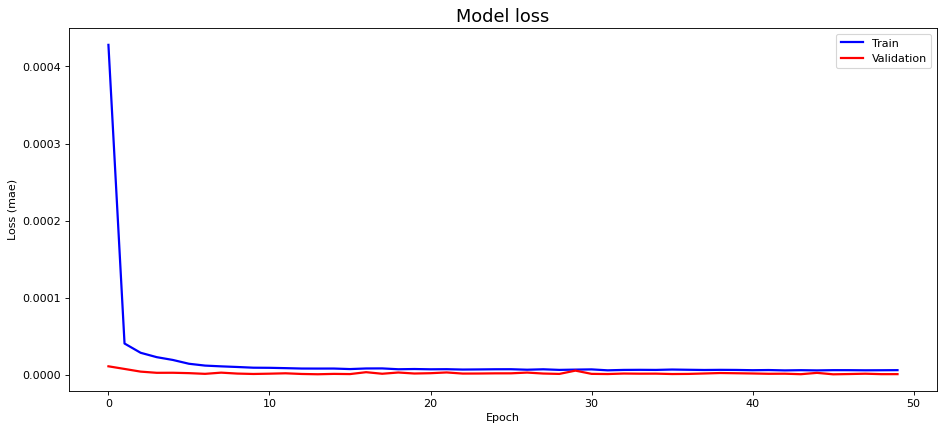

In [16]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

[[0.16344774]
 [0.16610558]
 [0.16433644]
 ...
 [0.22024825]
 [0.2203525 ]
 [0.22418526]]
(9940, 1)


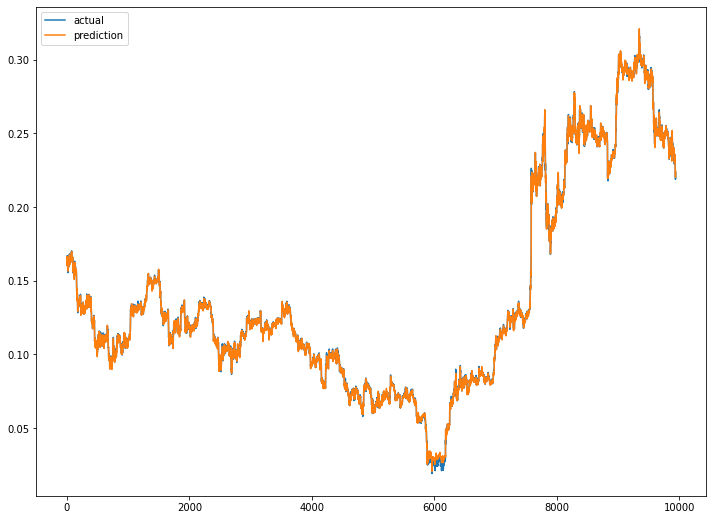

In [17]:
pred = model.predict(test_data)
print(pred)
print(pred.shape)

plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [18]:
model.save("model_0803_60_50000_epochs50.h5")

In [38]:
# auto_x = test_feature

# end_=576
# output_window = 288

# submission = np.zeros((980, 20, 5))

# for i in range(end_//output_window):
#     start_ = i *output_window
#     next_ = model.predict(auto_x)
#     auto_x=tf.concat([auto_x, next_], axis=1)
#     print(auto_x.shape)
#     submission[:, start_ : start_ + output_window, :] = next_

print(pred[9940])

IndexError: index 9940 is out of bounds for axis 0 with size 9940